Training labels after cleanup: ['negative' 'neutral' 'positive']


Loading text data:   9%|▊         | 344/4000 [00:00<00:01, 3331.21it/s]

Loading text data: 100%|██████████| 4000/4000 [00:01<00:00, 3856.06it/s]


Classes found by LabelEncoder: ['negative' 'neutral' 'positive']
Encoded labels range: 0 to 2


Loading image data: 100%|██████████| 4000/4000 [00:33<00:00, 119.68it/s]
C:\Users\cpj\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cpj\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Validating Epoch 1: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Epoch 1: Train Loss = 0.9052, Val Loss = 0.8335, Val Accuracy = 0.6162, Time = 479.16s
Epoch 2/10


Validating Epoch 2: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Epoch 2: Train Loss = 0.7874, Val Loss = 0.8010, Val Accuracy = 0.6400, Time = 494.63s
Epoch 3/10


Validating Epoch 3: 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Epoch 3: Train Loss = 0.7192, Val Loss = 0.7894, Val Accuracy = 0.6438, Time = 473.44s
Epoch 4/10


Validating Epoch 4: 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Epoch 4: Train Loss = 0.6519, Val Loss = 0.7798, Val Accuracy = 0.6450, Time = 486.69s
Epoch 5/10


Validating Epoch 5: 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


Epoch 5: Train Loss = 0.5876, Val Loss = 0.7869, Val Accuracy = 0.6412, Time = 500.89s
Epoch 6/10


Validating Epoch 6: 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Epoch 6: Train Loss = 0.5101, Val Loss = 0.8039, Val Accuracy = 0.6238, Time = 502.49s
Epoch 7/10


Validating Epoch 7: 100%|██████████| 25/25 [00:38<00:00,  1.54s/it]


Epoch 7: Train Loss = 0.4256, Val Loss = 0.8180, Val Accuracy = 0.6275, Time = 492.63s
Epoch 8/10


Validating Epoch 8: 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


Epoch 8: Train Loss = 0.3460, Val Loss = 0.8539, Val Accuracy = 0.6200, Time = 486.69s
Epoch 9/10


Validating Epoch 9: 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Epoch 9: Train Loss = 0.2682, Val Loss = 0.8989, Val Accuracy = 0.6175, Time = 469.38s
Epoch 10/10


Validating Epoch 10: 100%|██████████| 25/25 [00:39<00:00,  1.57s/it]


Epoch 10: Train Loss = 0.1937, Val Loss = 0.9412, Val Accuracy = 0.6112, Time = 488.86s


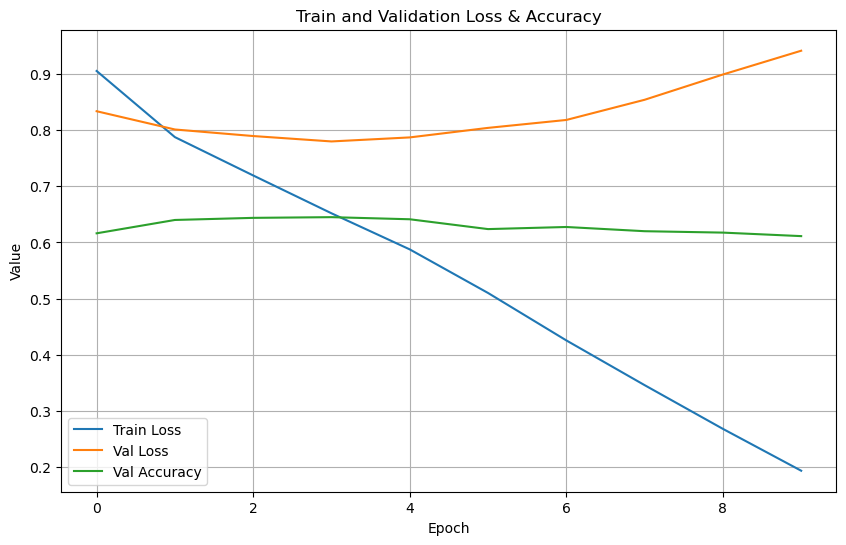

Total Training Time: 4875.75 seconds


In [5]:
#epoch=10
import os
import time
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm  # 用于过程可视化
import matplotlib.pyplot as plt  # 用于绘图

# 设置路径
data_dir = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/data"
train_file = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/train.txt"
test_file = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/test_without_label.txt"
result_file = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output/test_predictions_epoch10.csv"  # 保存预测结果
output_dir = "C:/Users/cpj/Desktop/ECNU/大三第一学期/当代人工智能/实验5/output"

# 创建输出目录（如果不存在）
os.makedirs(output_dir, exist_ok=True)

# 加载训练集标签
train_df = pd.read_csv(train_file, header=None, names=["guid", "label"])

# 清理数据确保标签合法
valid_labels = ["positive", "neutral", "negative"]  # 只允许这三种标签
train_df = train_df[train_df["label"].isin(valid_labels)]  # 过滤出合法数据

# 验证清理后的标签
print(f"Training labels after cleanup: {train_df['label'].unique()}")

# 文本预处理（使用 TF-IDF）
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # 限制最大特征数量
train_texts = []

# 读取文本内容
for guid in tqdm(train_df["guid"], desc="Loading text data"):
    text_path = os.path.join(data_dir, f"{guid}.txt")
    try:
        with open(text_path, "r", encoding="utf-8") as file:
            train_texts.append(file.read())
    except UnicodeDecodeError:
        try:
            with open(text_path, "r", encoding="gbk") as file:
                train_texts.append(file.read())
        except Exception as e:
            print(f"Warning: Unable to read text file {text_path} due to error: {e}")
            train_texts.append("[TEXT_ERROR]")  # 占位符
    except FileNotFoundError:
        print(f"Warning: File not found - {text_path}")
        train_texts.append("[TEXT_MISSING]")  # 占位符

# 对文本进行 TF-IDF 转换
X_text = tfidf_vectorizer.fit_transform(train_texts).toarray()

# 图像预处理
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 标签编码
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(train_df["label"])

# 打印编码后的标签及其范围
print(f"Classes found by LabelEncoder: {label_encoder.classes_}")
print(f"Encoded labels range: {y_labels.min()} to {y_labels.max()}")

# 加载图像
image_tensors = []
for guid in tqdm(train_df["guid"], desc="Loading image data"):
    image_path = os.path.join(data_dir, f"{guid}.jpg")
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Warning: Image file not found - {image_path}")
        image = Image.new("RGB", (224, 224))  # 如果图片不存在，生成空白图片
    image_tensor = image_transform(image)
    image_tensors.append(image_tensor)

# 切分数据集
X_train_text, X_val_text, X_train_images, X_val_images, y_train, y_val = train_test_split(
    X_text, image_tensors, y_labels, test_size=0.2, random_state=42
)

# 创建数据集类
class MultimodalDataset(Dataset):
    def __init__(self, text_features, image_tensors, labels=None):
        self.text_features = text_features
        self.image_tensors = image_tensors
        self.labels = labels

    def __len__(self):
        return len(self.text_features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.text_features[idx], dtype=torch.float32), self.image_tensors[idx], torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.text_features[idx], dtype=torch.float32), self.image_tensors[idx]

# 创建数据集和DataLoader
train_dataset = MultimodalDataset(X_train_text, X_train_images, y_train)
val_dataset = MultimodalDataset(X_val_text, X_val_images, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 模型设计
class MultimodalEmotionModel(nn.Module):
    def __init__(self, text_input_dim, num_classes):
        super(MultimodalEmotionModel, self).__init__()

        # 文本特征提取
        self.text_fc = nn.Linear(text_input_dim, 256)

        # 图像特征提取
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # 去掉ResNet的最后一层全连接层
        self.image_fc = nn.Linear(512, 256)  # ResNet18输出维度为512

        # 融合层
        self.fusion_fc = nn.Linear(512, num_classes)  # 动态设置输出类别数

    def forward(self, text_features, image_tensor):
        # 文本特征
        text_output = self.text_fc(text_features)

        # 图像特征
        image_features = self.resnet(image_tensor)
        image_features = self.image_fc(image_features)

        # 融合特征
        combined_features = torch.cat((text_output, image_features), dim=1)
        output = self.fusion_fc(combined_features)
        return output

# 确定输出类别数
num_classes = len(label_encoder.classes_)

# 实例化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalEmotionModel(text_input_dim=X_text.shape[1], num_classes=num_classes).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-5)

# 训练和评估
train_losses = []
val_losses = []
val_accuracies = []  # 保存每轮验证集准确率

start_time_total = time.time()  # 记录总时间
for epoch in range(10):
    print(f"Epoch {epoch+1}/{10}")
    epoch_start_time = time.time()  # 每个 Epoch 开始时间

    # 训练
    model.train()
    train_loss = 0
    for text_features, image_tensor, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        text_features, image_tensor, labels = text_features.to(device), image_tensor.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(text_features, image_tensor)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # 验证
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for text_features, image_tensor, labels in tqdm(val_dataloader, desc=f"Validating Epoch {epoch+1}"):
            text_features, image_tensor, labels = text_features.to(device), image_tensor.to(device), labels.to(device)
            output = model(text_features, image_tensor)
            loss = criterion(output, labels)
            val_loss += loss.item()

            # 计算准确率
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    # 当前 Epoch 时间
    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}, Time = {epoch_end_time - epoch_start_time:.2f}s")

# 绘制 Train Loss 和 Val Loss 折线图
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_accuracies, label="Val Accuracy")  # 新增
plt.title("Train and Validation Loss & Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "loss_accuracy_curve.png"))
plt.show()
# 总运行时间
end_time_total = time.time()
print(f"Total Training Time: {end_time_total - start_time_total:.2f} seconds")